In [1]:
from pathlib import Path

# Project root (one level above notebooks/)
PROJECT_ROOT = Path("..").resolve()

DATA_DIR = PROJECT_ROOT / "data"
OUTPUT_DIR = PROJECT_ROOT / "outputs"
SHAPEFILE_DIR = DATA_DIR / "shapefile"

print("Project root:", PROJECT_ROOT)


Project root: D:\MSc. Data Science\SEM - 4\UDAI HACKATHON\UIDAI_Operational_Stress


In [1]:
import pandas as pd
import glob

# ENROLMENT
enrolment_full = pd.concat(
    [pd.read_csv(f) for f in glob.glob("api_data_aadhar_enrolment_*.csv")],
    ignore_index=True
)

# DEMOGRAPHIC
demographic_full = pd.concat(
    [pd.read_csv(f) for f in glob.glob("api_data_aadhar_demographic_*.csv")],
    ignore_index=True
)

# BIOMETRIC
biometric_full = pd.concat(
    [pd.read_csv(f) for f in glob.glob("api_data_aadhar_biometric_*.csv")],
    ignore_index=True
)

# standardize date
for df in [enrolment_full, demographic_full, biometric_full]:
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

print("Loaded OK")


Loaded OK


In [2]:
START_DATE = "2025-04-01"
END_DATE   = "2025-10-31"

start = pd.to_datetime(START_DATE)
end   = pd.to_datetime(END_DATE)

enrol_time = enrolment_full[(enrolment_full["date"] >= start) & (enrolment_full["date"] <= end)]
demo_time  = demographic_full[(demographic_full["date"] >= start) & (demographic_full["date"] <= end)]
bio_time   = biometric_full[(biometric_full["date"] >= start) & (biometric_full["date"] <= end)]

print("After time filter:")
print("Enrolment:", enrol_time.shape)
print("Demographic:", demo_time.shape)
print("Biometric:", bio_time.shape)


After time filter:
Enrolment: (176653, 7)
Demographic: (491165, 6)
Biometric: (454748, 6)


In [3]:
print("Enrolment age columns:")
print([c for c in enrol_time.columns if "age" in c.lower()])

print("\nDemographic age columns:")
print([c for c in demo_time.columns if "age" in c.lower()])

print("\nBiometric age columns:")
print([c for c in bio_time.columns if "age" in c.lower()])


Enrolment age columns:
['age_0_5', 'age_5_17', 'age_18_greater']

Demographic age columns:
['demo_age_5_17', 'demo_age_17_']

Biometric age columns:
['bio_age_5_17', 'bio_age_17_']


In [4]:
enrol_age_totals = enrol_time[
    ["age_0_5", "age_5_17", "age_18_greater"]
].sum()

enrol_age_totals = enrol_age_totals.rename({
    "age_0_5": "Children (0–5)",
    "age_5_17": "Minors (5–17)",
    "age_18_greater": "Adults (18+)"
})

enrol_age_totals


Children (0–5)    520225
Minors (5–17)     223273
Adults (18+)       11210
dtype: int64

In [5]:
demo_age_cols = [c for c in demo_time.columns if "demo_age" in c]

demo_age_totals = demo_time[demo_age_cols].sum()

demo_age_totals


demo_age_5_17     802242
demo_age_17_     7284634
dtype: int64

In [6]:
bio_age_cols = [c for c in bio_time.columns if "bio_age" in c]

bio_age_totals = bio_time[bio_age_cols].sum()

bio_age_totals


bio_age_5_17    3434367
bio_age_17_     3429329
dtype: int64

In [7]:
enrol_age_share = (enrol_age_totals / enrol_age_totals.sum()) * 100
enrol_age_share


Children (0–5)    68.930633
Minors (5–17)     29.584025
Adults (18+)       1.485343
dtype: float64

In [8]:
demo_age_share = (demo_age_totals / demo_age_totals.sum()) * 100
demo_age_share


demo_age_5_17     9.920296
demo_age_17_     90.079704
dtype: float64

In [9]:
bio_age_share = (bio_age_totals / bio_age_totals.sum()) * 100
bio_age_share


bio_age_5_17    50.0367
bio_age_17_     49.9633
dtype: float64

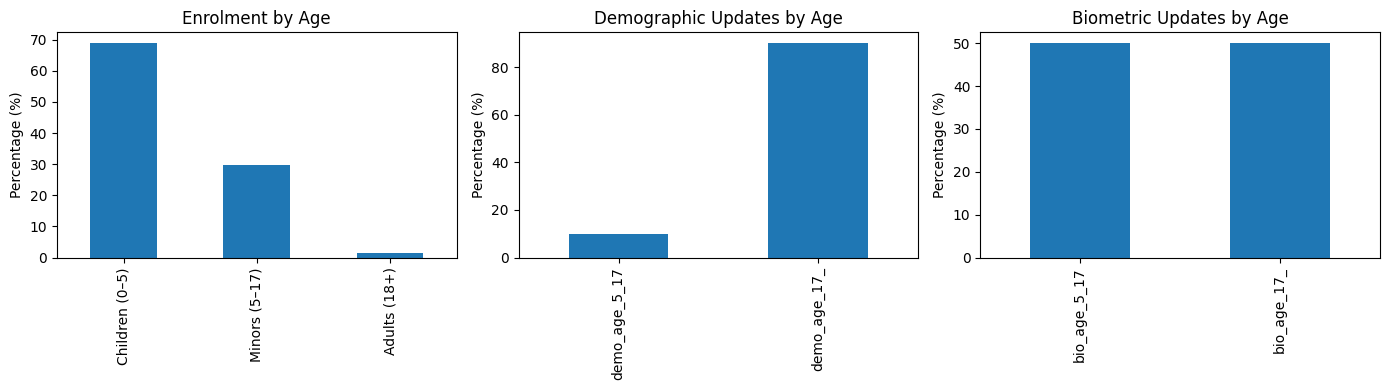

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(14,4))

enrol_age_share.plot(kind="bar", ax=ax[0], title="Enrolment by Age")
demo_age_share.plot(kind="bar", ax=ax[1], title="Demographic Updates by Age")
bio_age_share.plot(kind="bar", ax=ax[2], title="Biometric Updates by Age")

for a in ax:
    a.set_ylabel("Percentage (%)")

plt.tight_layout()
plt.show()


## Observed Age-Group Patterns (Facts)

From the national aggregation across common reporting days:

**Enrolment**
- Children (0–5): ~69%
- Minors (5–17): ~30%
- Adults (18+): ~1.5%

**Demographic Updates**
- Minors (5–17): ~10%
- Adults (17+): ~90%

**Biometric Updates**
- Minors (5–17): ~50%


## Why Do These Age-Group Patterns Exist?

These patterns are **policy-driven**, not random.

### 1. Enrolment is dominated by ages 0–5
- Aadhaar enrolment for children typically occurs soon after birth.
- This explains why nearly 70% of enrolments are for ages 0–5.
- Adult enrolment is rare because Aadhaar coverage among adults is already near-universal.

### 2. Demographic updates are dominated by adults
- Adults experience frequent life events requiring demographic changes:
  - address changes (migration for work)
  - name corrections
  - marital status updates
- Children have relatively stable demographic attributes.
- Hence, ~90% of demographic updates come from adults.

### 3. Biometric updates show a 50–50 split
- UIDAI mandates biometric updates at key growth milestones:
  - around age 5
  - around age 15
- Children’s fingerprints and iris patterns change significantly with growth.
- Adults also require biometric re-capture due to:
  - ageing
  - wear and tear
  - initial capture quality issues

**Therefore, biometric update load is structurally split between minors and adults.**


In [11]:
# Validate persistence of biometric age split across reporting days

bio_age_cols = [c for c in bio_time.columns if "age" in c.lower()]

daily_bio_split = (
    bio_time
    .groupby("date")[bio_age_cols]
    .sum()
)

daily_bio_pct = daily_bio_split.div(daily_bio_split.sum(axis=1), axis=0) * 100

daily_bio_pct.describe().round(2)


,bio_age_5_17,bio_age_17_
count,21.00,21.00
mean,50.16,49.84
std,2.10,2.10
min,44.66,46.76
25%,48.23,48.70
50%,50.77,49.23
75%,51.30,51.77
max,53.24,55.34


### Validation Result

The biometric age-group split is remarkably stable across all reporting days:
- Mean split ≈ 50% minors / 50% adults
- Low variance (σ ≈ 2%)

This confirms that biometric update demand is **structural and policy-driven**, not episodic or campaign-based. The system must therefore be designed to absorb this load continuously.
